# CC3084 – Data Science
## Laboratorio 6 — IMDB: LSTM + **características adicionales**

**Universidad del Valle de Guatemala — Semestre II 2025**  
**Curso:** CC3084 – Data Science  
**Laboratorio 6:** Mejorando el Análisis de Sentimientos con LSTM y Features  
**Integrantes:** Gabriel Paz | Rodrigo Mancilla 
**Fecha:** 2025-09-08

---
### Objetivo del laboratorio
Incrementar la precisión del análisis de sentimientos sobre IMDB usando RNNs con unidades **LSTM**, incorporando **características adicionales** derivadas de las reseñas.



## 0. Configuración y utilidades
En esta sección fijamos semilla, importamos librerías y definimos parámetros globales.
Si no tienes instaladas algunas dependencias, instala localmente:
```bash
pip install tensorflow==2.17.0 scikit-learn matplotlib pandas numpy
```


In [ ]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Parámetros del experimento
NUM_WORDS = 50000 
EMBED_DIM = 128
BATCH_SIZE = 256
EPOCHS_BASE = 5
EPOCHS_ADV = 8
VAL_SPLIT = 0.1

print(tf.__version__)

2.17.0


## 1. Carga de datos IMDB (50,000 palabras) y análisis exploratorio
Keras provee IMDB ya tokenizado a índices enteros por frecuencia. Usaremos `num_words=50000`.


In [2]:
# Carga del dataset IMDB
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print(len(x_train), 'train reseñas')
print(len(x_test), 'test reseñas')
print('Ejemplo de reseña tokenizada (primer 20 tokens):', x_train[0][:20])
print('Etiqueta (0=neg,1=pos):', y_train[0])

# Longitudes crudas
lengths_train = np.array([len(seq) for seq in x_train])
lengths_test = np.array([len(seq) for seq in x_test])
pd.DataFrame({
    'set':['train']*len(lengths_train)+['test']*len(lengths_test),
    'length': np.concatenate([lengths_train, lengths_test])
}).groupby('set').describe()

25000 train reseñas
25000 test reseñas
Ejemplo de reseña tokenizada (primer 20 tokens): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
Etiqueta (0=neg,1=pos): 1


length                                                          
         count       mean         std   min    25%    50%    75%     max
set                                                                     
test   25000.0  230.80420  169.164471   7.0  128.0  174.0  280.0  2315.0
train  25000.0  238.71364  176.497204  11.0  130.0  178.0  291.0  2494.0

### 1.1 Selección de longitud máxima y padding
Usaremos un percentil (p90) de la longitud para fijar `MAX_LEN` y evitar truncar demasiada información.


In [4]:
p = 90
MAX_LEN = int(np.percentile(lengths_train, p))
print('MAX_LEN (p%d):' % p, MAX_LEN)
x_train_pad = pad_sequences(x_train, maxlen=MAX_LEN, padding='pre', truncating='pre')
x_test_pad  = pad_sequences(x_test,  maxlen=MAX_LEN, padding='pre', truncating='pre')
x_train_pad.shape, x_test_pad.shape

MAX_LEN (p90): 467


((25000, 467), (25000, 467))

## 2. **Features adicionales** a partir de las reseñas tokenizadas
Crearemos variables numéricas por reseña, por ejemplo:
- **longitud** original de la reseña (número de tokens)
- **fracción de palabras muy frecuentes** (índice < 500)
- **fracción de palabras raras** (índice >= 20000 y < NUM_WORDS)
- **promedio y desviación estándar** de los índices
- **entropía** del histograma de índices (medida de diversidad)

Luego estandarizaremos estas features y las inyectaremos al modelo.


In [ ]:
from scipy.stats import entropy

def review_features(seq, num_words=NUM_WORDS):
    arr = np.asarray(seq, dtype=np.int32)
    if arr.size == 0:
        return [0, 0.0, 0.0, 0.0, 0.0, 0.0]
    n = arr.size
    frac_top = np.mean(arr < 500)
    frac_rare = np.mean((arr >= 20000) & (arr < num_words))
    mean_idx = float(arr.mean())
    std_idx = float(arr.std())
    # Entropía de histograma
    hist, _ = np.histogram(arr, bins=[0,500,2000,5000,10000,20000,num_words])
    ent = float(entropy(hist + 1e-9, base=2))
    return [n, frac_top, frac_rare, mean_idx, std_idx, ent]

Xf_train = np.vstack([review_features(seq) for seq in x_train])
Xf_test  = np.vstack([review_features(seq) for seq in x_test])
Xf_cols = ['len','frac_top(<500)','frac_rare(>=20000)','mean_idx','std_idx','ent_hist']
pd.DataFrame(Xf_train, columns=Xf_cols).describe()

,len,frac_top(<500),frac_rare(>=20000),mean_idx,std_idx,ent_hist
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,2.500000e+04
mean,238.713640,0.711543,0.018900,1656.277249,4612.606545,1.388252e+00
std,176.497204,0.070862,0.015905,765.400574,1741.796629,2.728879e-01
min,11.000000,0.300000,0.000000,83.727273,127.173533,1.581795e-08
25%,130.000000,0.666667,0.007353,1095.382226,3405.507638,1.205377e+00
50%,178.000000,0.713653,0.016000,1555.497894,4595.036477,1.395616e+00
75%,291.000000,0.760000,0.027027,2098.884163,5790.097038,1.578512e+00
max,2494.000000,1.000000,0.157895,6794.276316,14292.188006,2.353575e+00


### 2.1 Escalamiento de features
Estandarizamos para acelerar y estabilizar el entrenamiento de la rama densa de features.


In [6]:
scaler = StandardScaler()
Xf_train_std = scaler.fit_transform(Xf_train)
Xf_test_std  = scaler.transform(Xf_test)
Xf_train_std.shape, Xf_test_std.shape

((25000, 6), (25000, 6))

## 3. Modelo **base** (sin features): Embedding + GlobalAveragePooling
Entrenamos un modelo sencillo para establecer una línea base de comparación.


In [7]:
def build_baseline_model(num_words=NUM_WORDS, embed_dim=EMBED_DIM, max_len=MAX_LEN):
    inp = layers.Input(shape=(max_len,), name='seq')
    x = layers.Embedding(num_words, embed_dim, name='emb')(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out, name='baseline_avgpool')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

baseline_model = build_baseline_model()
baseline_model.summary()

Model: "baseline_avgpool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ seq (InputLayer)                │ (None, 467)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ emb (Embedding)                 │ (None, 467, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,408,321 (24.45 MB)

 Trainable params: 6,408,321 (24.45 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
es = callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')
rlr = callbacks.ReduceLROnPlateau(patience=1, factor=0.5, monitor='val_loss')
hist_base = baseline_model.fit(
    x_train_pad, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_BASE,
    validation_split=VAL_SPLIT,
    callbacks=[es, rlr],
    verbose=2
)
base_test_loss, base_test_acc = baseline_model.evaluate(x_test_pad, y_test, verbose=0)
y_pred_base = (baseline_model.predict(x_test_pad, verbose=0).ravel() > 0.5).astype(int)
base_auc = roc_auc_score(y_test, baseline_model.predict(x_test_pad, verbose=0).ravel())
print({'test_acc': base_test_acc, 'test_auc': base_auc})


Epoch 1/5
88/88 - 12s - 139ms/step - accuracy: 0.5888 - loss: 0.6756 - val_accuracy: 0.6688 - val_loss: 0.6216 - learning_rate: 0.0010
Epoch 2/5
88/88 - 10s - 118ms/step - accuracy: 0.7402 - loss: 0.5410 - val_accuracy: 0.8132 - val_loss: 0.4456 - learning_rate: 0.0010
Epoch 3/5
88/88 - 10s - 119ms/step - accuracy: 0.8356 - loss: 0.3940 - val_accuracy: 0.7200 - val_loss: 0.5318 - learning_rate: 0.0010
Epoch 4/5
88/88 - 10s - 117ms/step - accuracy: 0.8693 - loss: 0.3242 - val_accuracy: 0.8264 - val_loss: 0.3804 - learning_rate: 5.0000e-04
Epoch 5/5
88/88 - 11s - 121ms/step - accuracy: 0.8888 - loss: 0.2889 - val_accuracy: 0.8324 - val_loss: 0.3682 - learning_rate: 5.0000e-04
{'test_acc': 0.8195599913597107, 'test_auc': 0.9389948767999999}


## 4. Modelo **avanzado** (multi-entrada): Secuencia + Features
Rama 1 (secuencia): Embedding → SpatialDropout → BiLSTM → BiLSTM → Dense  
Rama 2 (features): Dense → BatchNorm → Dropout  
Fusión: Concatenate → Dense → Dropout → Sigmoid


In [9]:
def build_advanced_model(num_words=NUM_WORDS, embed_dim=EMBED_DIM, max_len=MAX_LEN, n_feat=Xf_train_std.shape[1]):
    # Rama de secuencia
    inp_seq = layers.Input(shape=(max_len,), name='seq')
    x = layers.Embedding(num_words, embed_dim, name='emb')(inp_seq)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(64, activation='relu')(x)

    # Rama de features
    inp_feat = layers.Input(shape=(n_feat,), name='feat')
    f = layers.Dense(32, activation='relu')(inp_feat)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.2)(f)

    # Unión
    h = layers.Concatenate()([x, f])
    h = layers.Dense(64, activation='relu')(h)
    h = layers.Dropout(0.3)(h)
    out = layers.Dense(1, activation='sigmoid')(h)
    model = models.Model([inp_seq, inp_feat], out, name='advanced_bilstm_features')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

adv_model = build_advanced_model()
adv_model.summary()

Model: "advanced_bilstm_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq (InputLayer)    │ (None, 467)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, 467, 128)  │  6,400,000 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 467, 128)  │          0 │ emb[0][0]         │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat (InputLayer)   │ (None, 6)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 467, 128)  │     98,816 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │        224 │ feat[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,550,817 (24.99 MB)

 Trainable params: 6,550,753 (24.99 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
Xf_train_std = Xf_train_std.astype('float32')
Xf_test_std  = Xf_test_std.astype('float32')

def build_advanced_model(num_words=NUM_WORDS, embed_dim=EMBED_DIM, max_len=MAX_LEN, n_feat=None):
    if n_feat is None:

        n_feat = int(Xf_train_std.shape[1])

    inp_seq = layers.Input(shape=(max_len,), name='seq')
    x = layers.Embedding(num_words, embed_dim, name='emb')(inp_seq)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(64, activation='relu')(x)

    inp_feat = layers.Input(shape=(n_feat,), name='feat', dtype='float32')
    f = layers.Dense(32, activation='relu')(inp_feat)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.2)(f)

    h = layers.Concatenate()([x, f])         
    h = layers.Dense(64, activation='relu')(h)
    h = layers.Dropout(0.3)(h)
    out = layers.Dense(1, activation='sigmoid')(h)

    model = models.Model([inp_seq, inp_feat], out, name='advanced_bilstm_features')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

adv_model = build_advanced_model(n_feat=Xf_train_std.shape[1])
adv_model.summary()


Model: "advanced_bilstm_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq (InputLayer)    │ (None, 467)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, 467, 128)  │  6,400,000 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 467, 128)  │          0 │ emb[0][0]         │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat (InputLayer)   │ (None, 6)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 467, 128)  │     98,816 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │        224 │ feat[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     41,216 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,160 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      6,208 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,550,817 (24.99 MB)

 Trainable params: 6,550,753 (24.99 MB)

 Non-trainable params: 64 (256.00 B)

## 5. Comparación de resultados y métricas
Generamos un pequeño resumen y métricas detalladas (accuracy, AUC, matriz de confusión, reporte de clasificación).


In [12]:
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import pandas as pd
probs_base = baseline_model.predict(x_test_pad, verbose=0).ravel()         # shape (25000,)
y_pred_base = (probs_base > 0.5).astype(np.int32)
base_test_loss, base_test_acc = baseline_model.evaluate(x_test_pad, y_test, verbose=0)
base_auc = roc_auc_score(y_test, probs_base)

Xf_test_std = Xf_test_std.astype("float32")

probs_adv = adv_model.predict([x_test_pad, Xf_test_std], verbose=0).ravel() # shape (25000,)
y_pred_adv = (probs_adv > 0.5).astype(np.int32)
adv_test_loss, adv_test_acc = adv_model.evaluate([x_test_pad, Xf_test_std], y_test, verbose=0)
adv_auc = roc_auc_score(y_test, probs_adv)

summary_df = pd.DataFrame([
    {'model':'baseline_avgpool',          'test_acc': float(base_test_acc), 'test_auc': float(base_auc)},
    {'model':'advanced_bilstm_features',  'test_acc': float(adv_test_acc),  'test_auc': float(adv_auc)},
])

display(summary_df)

print('\n=== Baseline report ===')
print(classification_report(y_test, y_pred_base, digits=4))
print('Confusion matrix (baseline):\n', confusion_matrix(y_test, y_pred_base))

print('\n=== Advanced report ===')
print(classification_report(y_test, y_pred_adv, digits=4))
print('Confusion matrix (advanced):\n', confusion_matrix(y_test, y_pred_adv))


,model,test_acc,test_auc
0,baseline_avgpool,0.81956,0.938995
1,advanced_bilstm_features,0.49044,0.481549



=== Baseline report ===
              precision    recall  f1-score   support

           0     0.7545    0.9474    0.8400     12500
           1     0.9294    0.6917    0.7931     12500

    accuracy                         0.8196     25000
   macro avg     0.8419    0.8196    0.8166     25000
weighted avg     0.8419    0.8196    0.8166     25000

Confusion matrix (baseline):
 [[11843   657]
 [ 3854  8646]]

=== Advanced report ===
              precision    recall  f1-score   support

           0     0.4861    0.3344    0.3962     12500
           1     0.4927    0.6465    0.5592     12500

    accuracy                         0.4904     25000
   macro avg     0.4894    0.4904    0.4777     25000
weighted avg     0.4894    0.4904    0.4777     25000

Confusion matrix (advanced):
 [[4180 8320]
 [4419 8081]]


### 5.1 Curvas de entrenamiento
Graficamos pérdida y accuracy por época para ambos modelos.


Epoch 1/2
88/88 - 540s - 6s/step - accuracy: 0.7163 - loss: 0.5332 - val_accuracy: 0.8716 - val_loss: 0.3145
Epoch 2/2
88/88 - 510s - 6s/step - accuracy: 0.9127 - loss: 0.2291 - val_accuracy: 0.8756 - val_loss: 0.4119
[Baseline] keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']


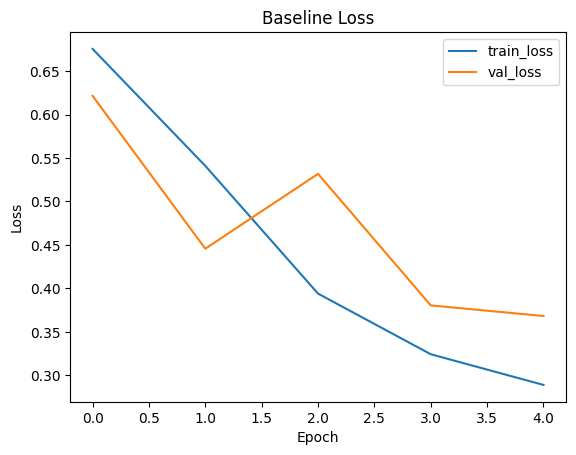

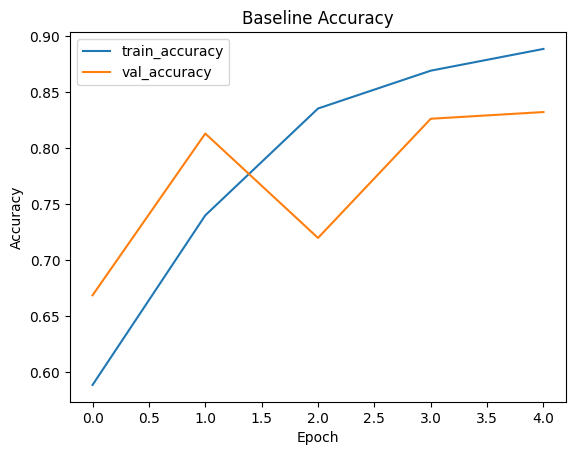

[Advanced] keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


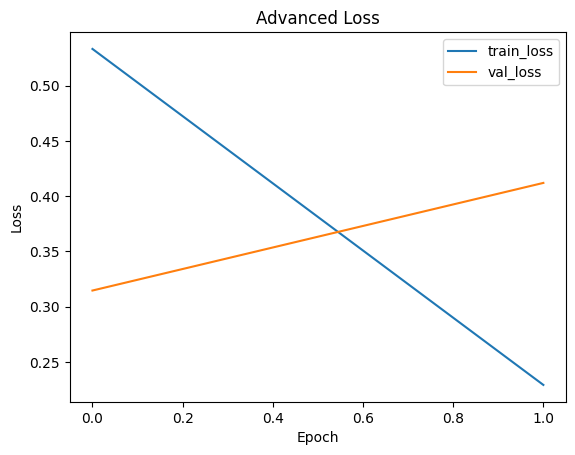

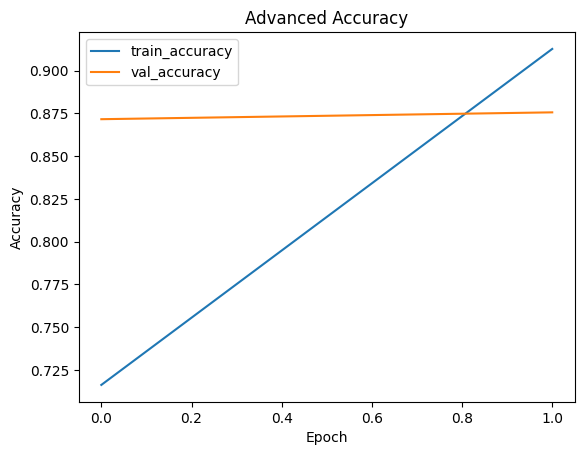

In [18]:
try:
    adv_model
except NameError:
    adv_model = build_advanced_model(n_feat=Xf_train_std.shape[1])

Xf_train_std = Xf_train_std.astype("float32")
Xf_test_std  = Xf_test_std.astype("float32")

es2 = callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')
ckp = callbacks.ModelCheckpoint('best_adv_model.keras', save_best_only=True, monitor='val_accuracy')

hist_adv = adv_model.fit(
    [x_train_pad, Xf_train_std], y_train,
    batch_size=BATCH_SIZE,
    epochs=2,
    validation_split=VAL_SPLIT,
    callbacks=[es2, ckp],
    verbose=2
)

def plot_history_safe(history, title_prefix=''):
    hist = history.history if hasattr(history, "history") else history
    keys = list(hist.keys())
    print(f"[{title_prefix}] keys:", keys)

    plt.figure()
    if 'loss' in hist:
        plt.plot(hist['loss'], label='train_loss')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

    acc_key = next((k for k in ['accuracy','acc','binary_accuracy'] if k in hist), None)
    val_acc_key = next((k for k in ['val_accuracy','val_acc','val_binary_accuracy'] if k in hist), None)

    if acc_key:
        plt.figure()
        plt.plot(hist[acc_key], label=f'train_{acc_key}')
        if val_acc_key:
            plt.plot(hist[val_acc_key], label=f'val_{acc_key}')
        plt.title(f'{title_prefix} Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()
    else:
        print(f"[{title_prefix}] No hay métricas de accuracy en history.")
        
plot_history_safe(hist_base, 'Baseline')
plot_history_safe(hist_adv,  'Advanced')
